In [1]:
    import hopsworks
    import pandas as pd
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    import seaborn as sns
    from matplotlib import pyplot
    from hsml.schema import Schema
    from hsml.model_schema import ModelSchema
    import joblib
    import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/206998
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)

In [4]:
# Read the features split the data into training and testing sets of features (X) and labels (y)
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.99s) 


In [5]:
X_train.fillna(X_train.mean(), inplace=True)
y_train.fillna(y_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
y_test.fillna(y_test.mean(), inplace=True)

In [6]:
# Train our model with the Scikit-learn decision tree algorithm using our features (X_train) and labels (y_train)
from sklearn import tree

model = tree.DecisionTreeClassifier( criterion='gini', 
                                          splitter='best',
                                          max_depth=None,
                                          min_samples_leaf=3,
                                          ccp_alpha=0.0,
                                          )
model = model.fit(X_train, y_train)

In [7]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
'''from sklearn.neighbors import KNeighborsClassifier
    
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())'''

'from sklearn.neighbors import KNeighborsClassifier\n    \nmodel = KNeighborsClassifier(n_neighbors=2)\nmodel.fit(X_train, y_train.values.ravel())'

In [8]:
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
1,1,8.5,0.655,0.49,6.1,0.122,34.0,151.0,1.00100,3.31,1.14,9.3
3,0,7.2,0.230,0.39,14.2,0.058,49.0,192.0,0.99790,2.98,0.48,9.0
4,0,7.4,0.250,0.49,1.1,0.042,35.0,156.0,0.99170,3.13,0.55,11.3
6,0,6.2,0.280,0.45,7.5,0.045,46.0,203.0,0.99573,3.26,0.46,9.2
8,0,5.6,0.260,0.27,10.6,0.030,27.0,119.0,0.99470,3.40,0.34,10.7
...,...,...,...,...,...,...,...,...,...,...,...,...
5358,0,8.1,0.280,0.39,1.9,0.029,18.0,79.0,0.99230,3.21,0.52,11.8
5359,0,6.4,0.290,0.28,1.1,0.055,9.0,160.0,0.99405,3.42,0.50,9.1
5360,1,7.0,0.540,0.31,2.1,0.079,39.0,55.0,0.99560,3.39,0.84,11.4
5361,0,5.3,0.585,0.31,7.1,0.044,34.0,145.0,0.99450,3.34,0.57,9.7


In [9]:
y_train

,quality
1,5
3,7
4,5
6,6
8,7
...,...
5358,6
5359,7
5360,6
5361,6


In [12]:
feature_names = ["type","fixed_acidity","volatile_acidity","citric_acid","residual_sugar","chlorides","free_sulfur_dioxide","total_sulfur_dioxide","density","ph","sulphates","alcohol"]
result_train = model.score(X_train, y_train)
result_test = model.score(X_test, y_test)
print('result_train:', result_train,        # accuracy of training dataset
      '\n', 'result_test:', result_test)    # accuracy of testing dataset
print([*zip(feature_names, model.feature_importances_)])   # importance number of different attributes

result_train: 0.8601398601398601 
 result_test: 0.4594594594594595
[('type', 0.0012221588518932503), ('fixed_acidity', 0.06564541716735875), ('volatile_acidity', 0.11049658827069395), ('citric_acid', 0.06135343211119034), ('residual_sugar', 0.07158237371175603), ('chlorides', 0.08813815540531011), ('free_sulfur_dioxide', 0.08338892703111077), ('total_sulfur_dioxide', 0.07703472904432619), ('density', 0.0966058862851406), ('ph', 0.08154477930141987), ('sulphates', 0.08816528023143136), ('alcohol', 0.17482227258836872)]


In [13]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [14]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '4': {'precision': 0.18181818181818182, 'recall': 0.25, 'f1-score': 0.2105263157894737, 'support': 40.0}, '5': {'precision': 0.4868035190615836, 'recall': 0.4811594202898551, 'f1-score': 0.4839650145772595, 'support': 345.0}, '6': {'precision': 0.5222929936305732, 'recall': 0.5125, 'f1-score': 0.5173501577287065, 'support': 480.0}, '7': {'precision': 0.38372093023255816, 'recall': 0.38372093023255816, 'f1-score': 0.3837209302325581, 'support': 172.0}, '8': {'precision': 0.18518518518518517, 'recall': 0.15151515151515152, 'f1-score': 0.16666666666666666, 'support': 33.0}, 'accuracy': 0.4594594594594595, 'macro avg': {'precision': 0.293303468321347, 'recall': 0.29648258367292746, 'f1-score': 0.2937048474991108, 'support': 1073.0}, 'weighted avg': {'precision': 0.46414882516566625, 'recall': 0.4594594594594595, 'f1-score': 0.46152568347671263, 'support': 1073.0}}


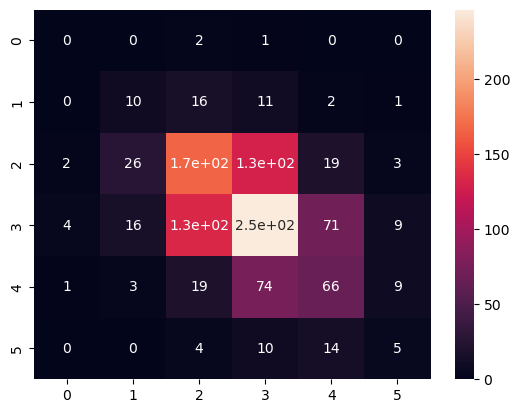

In [15]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results)
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [16]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/206998/models/wine_model/2


Model(name: 'wine_model', version: 2)